# Sectoral Features TDABM

In [1]:
!pip install kmapper
!pip install pyballmapper

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import kmapper as km
import pyballmapper as pbm
import statistics
import seaborn as sb
import networkx as nx
from matplotlib.colors import ListedColormap
from matplotlib import colormaps as cm
from sklearn.preprocessing import StandardScaler

In [3]:
sectoral_df = pd.read_csv('sectoral_features_final.csv')

In [4]:
# Remove all rows with any null values in sectoral_df
sectoral_df = sectoral_df.dropna()

In [5]:
sectoral_df 

,industry_code,year,automation_index,total_employment,uk_employees,eu_employees,non_eu_employees,skill_intensity,median_pay,brexit_policy_flag,skilled_worker_visa_eligibility_share,tier2_visa_eligibility_share,vacancies,union_presence_score,pub_sec_high,pub_sec_low,pub_sec_medium,english_requirement_score,female_share,male_share,migrant_share,turnover_rate
0,A,2015.0,0.187,191292.0,151042.0,37833.0,2442.0,1.755,1393.17,0.0,1.00,0.05,14665.0,0.2,0.0,1.0,0.0,0.2,0.335088,0.664912,0.210542,0.076663
1,A,2016.0,0.187,191900.0,151108.0,38442.0,2367.0,1.760,1447.92,0.0,1.00,0.05,15015.0,0.2,0.0,1.0,0.0,0.2,0.338328,0.661672,0.212654,0.078244
2,A,2017.0,0.187,192308.0,151858.0,38258.0,2200.0,1.765,1516.58,0.0,1.00,0.05,15790.0,0.2,0.0,1.0,0.0,0.2,0.340015,0.659985,0.210383,0.082108
3,A,2018.0,0.187,193233.0,153067.0,37917.0,2242.0,1.770,1573.75,0.0,1.00,0.05,16695.0,0.2,0.0,1.0,0.0,0.2,0.345489,0.654511,0.207823,0.086398
4,A,2019.0,0.187,196717.0,156283.0,37525.0,2900.0,1.775,1636.25,0.0,1.00,0.05,16552.0,0.2,0.0,1.0,0.0,0.2,0.350963,0.649037,0.205499,0.084140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,T,2020.0,0.081,217925.0,185850.0,14275.0,17783.0,1.500,976.42,0.0,1.00,0.00,143.0,0.1,0.0,1.0,0.0,0.3,0.746996,0.253004,0.147107,0.000654
196,T,2021.0,0.081,227233.0,193567.0,15150.0,18508.0,1.500,1003.42,1.0,0.05,0.05,228.0,0.1,0.0,1.0,0.0,0.3,0.739674,0.260326,0.148122,0.001005
197,T,2022.0,0.081,208208.0,172775.0,15625.0,19800.0,1.500,1046.83,1.0,0.05,0.05,311.0,0.1,0.0,1.0,0.0,0.3,0.737588,0.262412,0.170142,0.001492
198,T,2023.0,0.081,195600.0,158500.0,15083.0,22000.0,1.500,1098.33,1.0,0.05,0.05,256.0,0.1,0.0,1.0,0.0,0.3,0.735066,0.264934,0.189588,0.001307


In [6]:
sectoral_df.dtypes

industry_code                             object
year                                     float64
automation_index                         float64
total_employment                         float64
uk_employees                             float64
eu_employees                             float64
non_eu_employees                         float64
skill_intensity                          float64
median_pay                               float64
brexit_policy_flag                       float64
skilled_worker_visa_eligibility_share    float64
tier2_visa_eligibility_share             float64
vacancies                                float64
union_presence_score                     float64
pub_sec_high                             float64
pub_sec_low                              float64
pub_sec_medium                           float64
english_requirement_score                float64
female_share                             float64
male_share                               float64
migrant_share       

In [7]:
# Assuming the columns for the number of UK, EU, and non-EU employees are named 'uk_employees', 'eu_employees', and 'non_eu_employees' respectively
# and the total number of employees is in a column named 'total_employees'

sectoral_df['proportion_uk_employees'] = sectoral_df['uk_employees'] / sectoral_df['total_employment']
sectoral_df['proportion_eu_employees'] = sectoral_df['eu_employees'] / sectoral_df['total_employment']
sectoral_df['proportion_non_eu_employees'] = sectoral_df['non_eu_employees'] / sectoral_df['total_employment']

In [8]:
sectoral_df

,industry_code,year,automation_index,total_employment,uk_employees,eu_employees,non_eu_employees,skill_intensity,median_pay,brexit_policy_flag,skilled_worker_visa_eligibility_share,tier2_visa_eligibility_share,vacancies,union_presence_score,pub_sec_high,pub_sec_low,pub_sec_medium,english_requirement_score,female_share,male_share,migrant_share,turnover_rate,proportion_uk_employees,proportion_eu_employees,proportion_non_eu_employees
0,A,2015.0,0.187,191292.0,151042.0,37833.0,2442.0,1.755,1393.17,0.0,1.00,0.05,14665.0,0.2,0.0,1.0,0.0,0.2,0.335088,0.664912,0.210542,0.076663,0.789589,0.197776,0.012766
1,A,2016.0,0.187,191900.0,151108.0,38442.0,2367.0,1.760,1447.92,0.0,1.00,0.05,15015.0,0.2,0.0,1.0,0.0,0.2,0.338328,0.661672,0.212654,0.078244,0.787431,0.200323,0.012335
2,A,2017.0,0.187,192308.0,151858.0,38258.0,2200.0,1.765,1516.58,0.0,1.00,0.05,15790.0,0.2,0.0,1.0,0.0,0.2,0.340015,0.659985,0.210383,0.082108,0.789660,0.198941,0.011440
3,A,2018.0,0.187,193233.0,153067.0,37917.0,2242.0,1.770,1573.75,0.0,1.00,0.05,16695.0,0.2,0.0,1.0,0.0,0.2,0.345489,0.654511,0.207823,0.086398,0.792137,0.196224,0.011603
4,A,2019.0,0.187,196717.0,156283.0,37525.0,2900.0,1.775,1636.25,0.0,1.00,0.05,16552.0,0.2,0.0,1.0,0.0,0.2,0.350963,0.649037,0.205499,0.084140,0.794456,0.190756,0.014742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,T,2020.0,0.081,217925.0,185850.0,14275.0,17783.0,1.500,976.42,0.0,1.00,0.00,143.0,0.1,0.0,1.0,0.0,0.3,0.746996,0.253004,0.147107,0.000654,0.852816,0.065504,0.081601
196,T,2021.0,0.081,227233.0,193567.0,15150.0,18508.0,1.500,1003.42,1.0,0.05,0.05,228.0,0.1,0.0,1.0,0.0,0.3,0.739674,0.260326,0.148122,0.001005,0.851844,0.066672,0.081449
197,T,2022.0,0.081,208208.0,172775.0,15625.0,19800.0,1.500,1046.83,1.0,0.05,0.05,311.0,0.1,0.0,1.0,0.0,0.3,0.737588,0.262412,0.170142,0.001492,0.829819,0.075045,0.095097
198,T,2023.0,0.081,195600.0,158500.0,15083.0,22000.0,1.500,1098.33,1.0,0.05,0.05,256.0,0.1,0.0,1.0,0.0,0.3,0.735066,0.264934,0.189588,0.001307,0.810327,0.077111,0.112474


In [9]:
# Create pre- and post- brexit filtered dataframes and reset their indexes
pre = sectoral_df[(sectoral_df["year"] >= 2015) & (sectoral_df["year"] <= 2019)].copy().reset_index(drop=True)
post = sectoral_df[(sectoral_df["year"] >= 2021)].copy().reset_index(drop=True)

### Pre- and post-Brexit TDABM

In [10]:
# Features
feature_cols = [
    "automation_index","english_requirement_score","female_share","male_share",
    "median_pay","migrant_share","pub_sec_high","pub_sec_low","pub_sec_medium",
    "skill_intensity","skilled_worker_visa_eligibility_share",
    "tier2_visa_eligibility_share","turnover_rate","union_presence_score","vacancies"
]
color_cols = ["proportion_eu_employees", "proportion_non_eu_employees"]

pre  = pre.dropna(subset=feature_cols + color_cols).copy()
post = post.dropna(subset=feature_cols + color_cols).copy()

In [11]:
# Scaling on combined for comparability
bothX = pd.concat([pre[feature_cols], post[feature_cols]], axis=0)
scaler = StandardScaler().fit(bothX.to_numpy())
X_pre  = scaler.transform(pre[feature_cols].to_numpy())
X_post = scaler.transform(post[feature_cols].to_numpy())
c_pre_eu  = pre['proportion_eu_employees'].to_numpy()
c_post_eu = post['proportion_eu_employees'].to_numpy()
c_pre_non_eu  = pre['proportion_non_eu_employees'].to_numpy()
c_post_non_eu = post['proportion_non_eu_employees'].to_numpy()

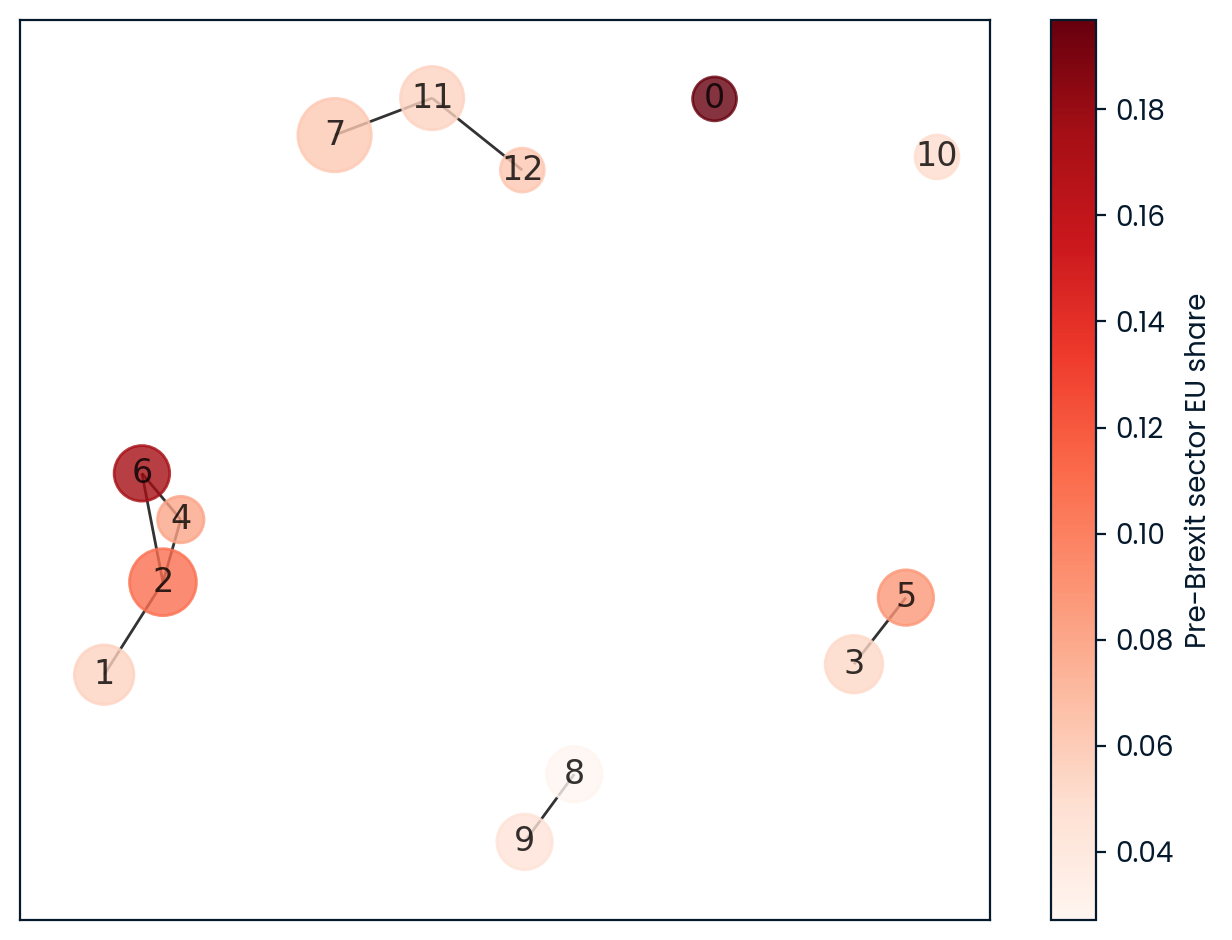

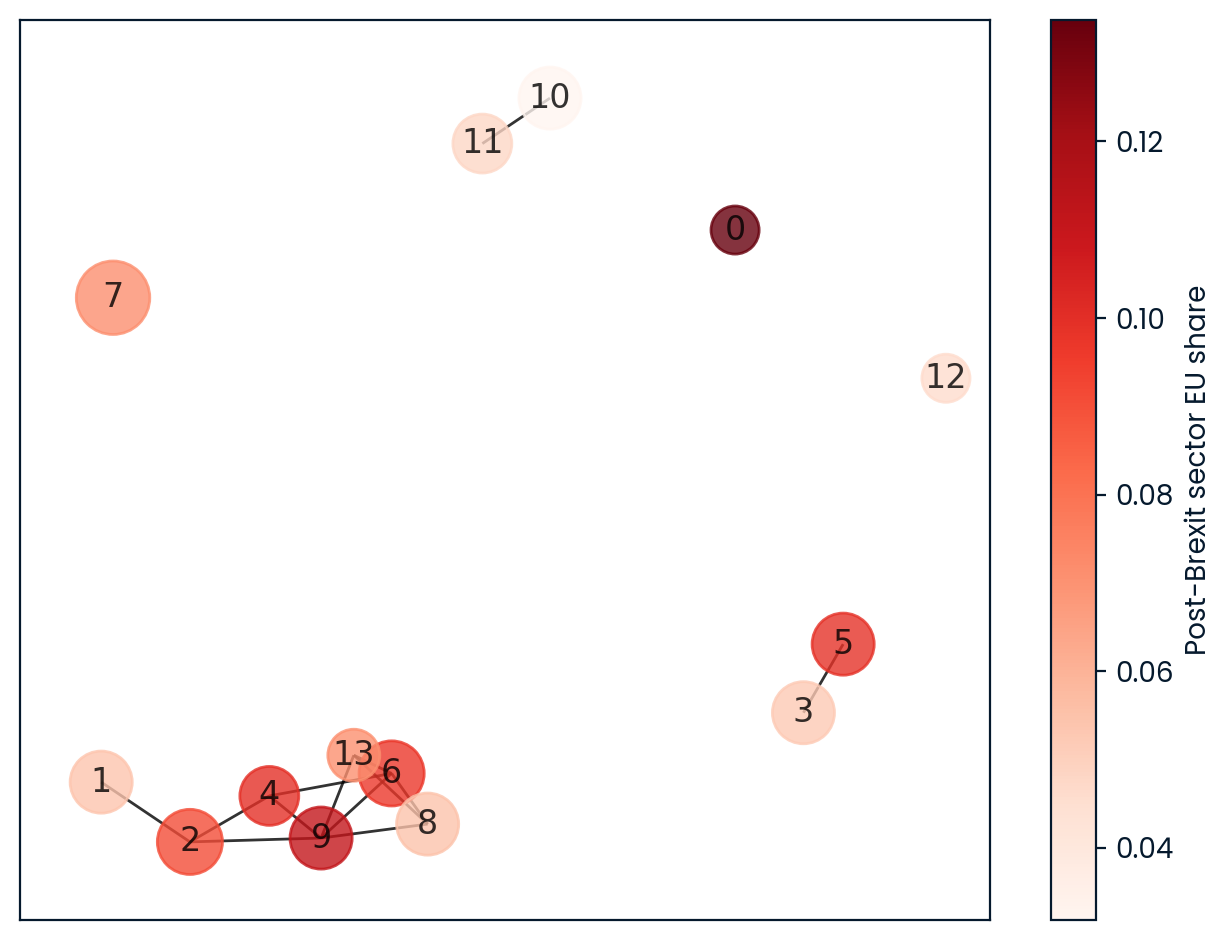

In [12]:
# Ball Mapper graphs
bm_pre  = pbm.BallMapper(X=X_pre,  eps=3.1, coloring_df=pd.DataFrame({"eu_share": c_pre_eu})) 
bm_post = pbm.BallMapper(X=X_post, eps=3.1, coloring_df=pd.DataFrame({"eu_share": c_post_eu}))
fig, ax = plt.subplots()
bm_pre.draw_networkx(ax=ax, coloring_variable="eu_share", colorbar=True,
                     colorbar_label="Pre-Brexit sector EU share", pos=nx.spring_layout(bm_pre.Graph, k=0.5, seed=1))
fig.tight_layout()
fig.savefig("bm_pre_eu_share.png", dpi=150)

fig, ax = plt.subplots()
bm_post.draw_networkx(ax=ax, coloring_variable="eu_share", colorbar=True,
                      colorbar_label="Post-Brexit sector EU share", pos=nx.spring_layout(bm_post.Graph, k=0.5, seed=1))
fig.tight_layout()
fig.savefig("bm_post_eu_share.png", dpi=150)

Now colour by non_eu:

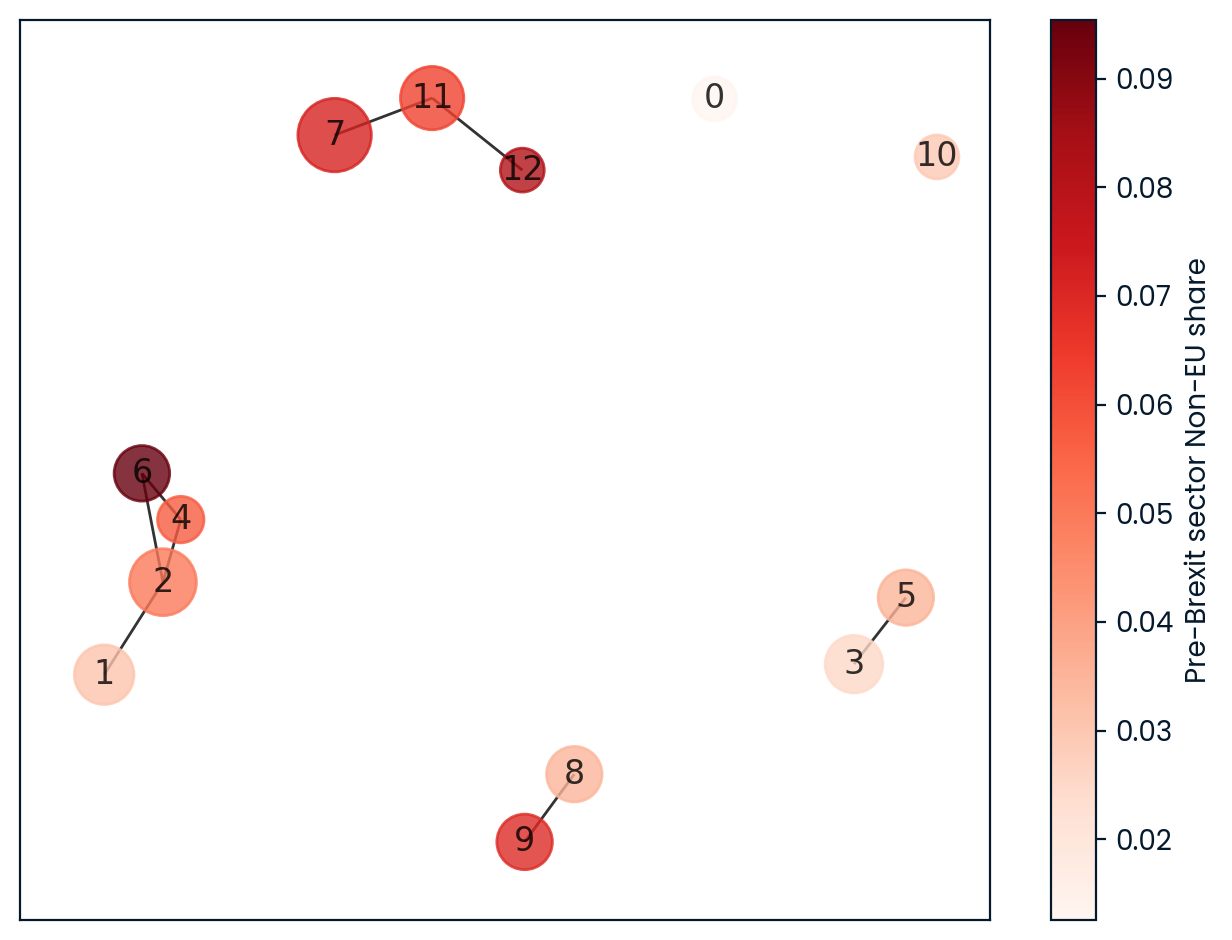

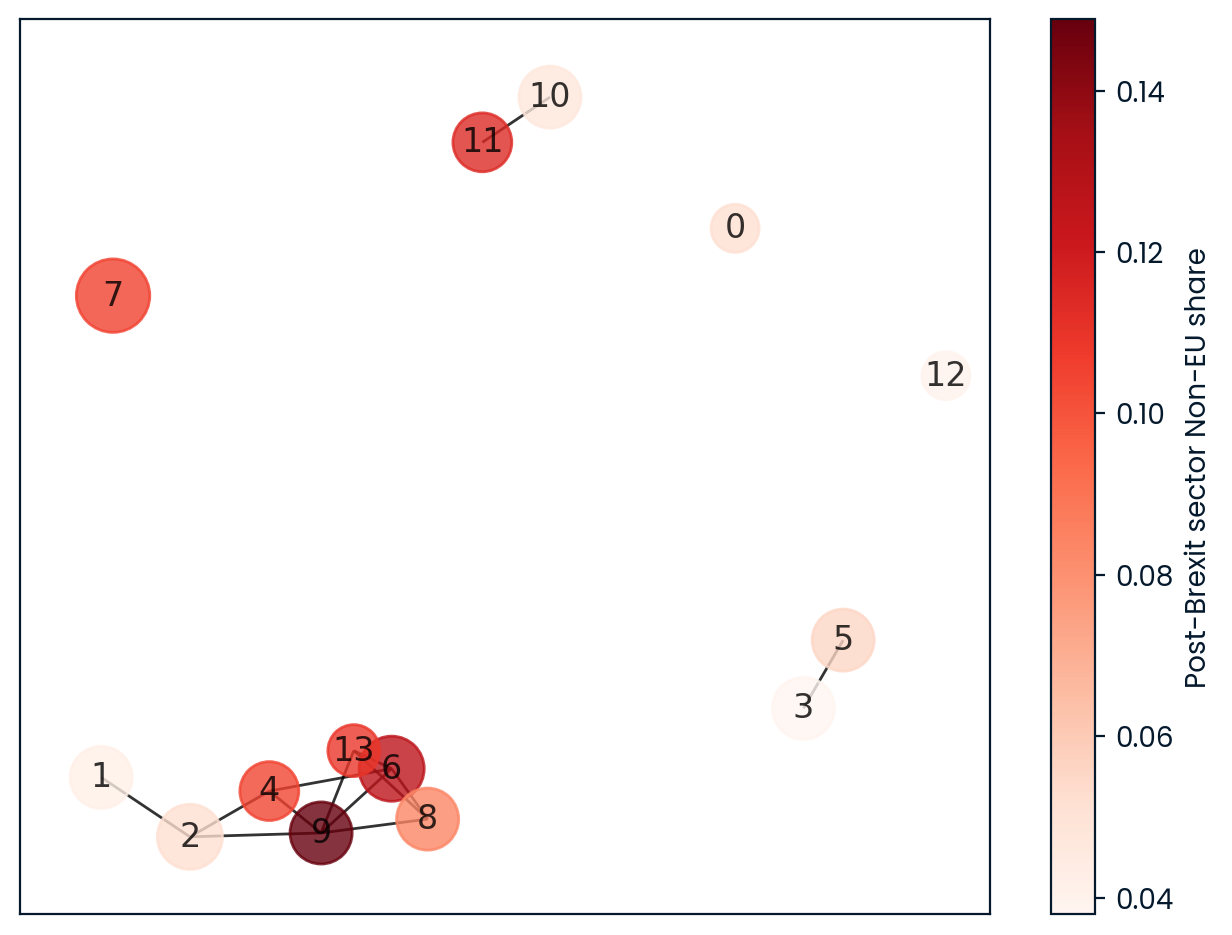

In [13]:
# Build Ball Mapper graphs coloured by NON-EU share
bm_pre  = pbm.BallMapper(X=X_pre,  eps=3.1,
                         coloring_df=pd.DataFrame({"non_eu_share": c_pre_non_eu}))
bm_post = pbm.BallMapper(X=X_post, eps=3.1,
                         coloring_df=pd.DataFrame({"non_eu_share": c_post_non_eu}))

# --- Pre-Brexit plot ---
fig, ax = plt.subplots()
bm_pre.draw_networkx(ax=ax,
                     coloring_variable="non_eu_share",
                     colorbar=True,
                     colorbar_label="Pre-Brexit sector Non-EU share",
                     pos=nx.spring_layout(bm_pre.Graph, k=0.5, seed=1))
fig.tight_layout()
fig.savefig("bm_pre_non_eu_share.png", dpi=150)

# --- Post-Brexit plot ---
fig, ax = plt.subplots()
bm_post.draw_networkx(ax=ax,
                      coloring_variable="non_eu_share",
                      colorbar=True,
                      colorbar_label="Post-Brexit sector Non-EU share",
                      pos=nx.spring_layout(bm_post.Graph, k=0.5, seed=1))
fig.tight_layout()
fig.savefig("bm_post_non_eu_share.png", dpi=150)

### Points and Balls

Will first find ball membership of all points in pre and post-brexit networks for analysis

In [14]:
pb_pre = bm_pre.points_and_balls()
pb_post = bm_post.points_and_balls()
pb_pre
pb_post

,point,ball
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
...,...,...
100,75,13
101,76,13
102,77,13
103,78,13


In [15]:
post.head()

,industry_code,year,automation_index,total_employment,uk_employees,eu_employees,non_eu_employees,skill_intensity,median_pay,brexit_policy_flag,skilled_worker_visa_eligibility_share,tier2_visa_eligibility_share,vacancies,union_presence_score,pub_sec_high,pub_sec_low,pub_sec_medium,english_requirement_score,female_share,male_share,migrant_share,turnover_rate,proportion_uk_employees,proportion_eu_employees,proportion_non_eu_employees
0,A,2021.0,0.187,196392.0,161308.0,29767.0,5292.0,1.785,1784.00,1.0,0.3,0.3,18272.0,0.2,0.0,1.0,0.0,0.2,0.354390,0.645610,0.178512,0.093037,0.821357,0.151569,0.026946
1,A,2022.0,0.187,200633.0,163208.0,27608.0,9808.0,1.790,1885.67,1.0,0.3,0.3,24860.0,0.2,0.0,1.0,0.0,0.2,0.360713,0.639287,0.186493,0.123908,0.813465,0.137604,0.048885
2,A,2023.0,0.187,200167.0,162500.0,25375.0,12292.0,1.795,2011.33,1.0,0.3,0.3,20447.0,0.2,0.0,1.0,0.0,0.2,0.365606,0.634394,0.188177,0.102148,0.811822,0.126769,0.061409
3,A,2024.0,0.187,203000.0,164564.0,24164.0,14273.0,1.800,2155.58,1.0,0.3,0.3,17242.0,0.2,0.0,1.0,0.0,0.2,0.363595,0.636405,0.189342,0.084934,0.810660,0.119034,0.070310
4,B,2021.0,0.231,49183.0,45592.0,1833.0,1783.0,2.291,3969.25,1.0,0.5,0.5,1250.0,0.3,0.0,1.0,0.0,0.4,0.168038,0.831962,0.073534,0.025415,0.926987,0.037269,0.036252


In [16]:
# --- Pre-Brexit mapping ---
pb_pre = bm_pre.points_and_balls()
pb_pre = pb_pre.merge(
    pre.reset_index()[["index", "year", "industry_code"]],
    left_on="point", right_on="index", how="left"
).drop(columns=["index"])

# --- Post-Brexit mapping ---
pb_post = bm_post.points_and_balls()
pb_post = pb_post.merge(
    post.reset_index()[["index", "year", "industry_code"]],
    left_on="point", right_on="index", how="left"
).drop(columns=["index"])

# Preview
print(pb_pre.head())
print(pb_post.head())

   point  ball    year industry_code
0      0     0  2015.0             A
1      1     0  2016.0             A
2      2     0  2017.0             A
3      3     0  2018.0             A
4      4     0  2019.0             A
   point  ball    year industry_code
0      0     0  2021.0             A
1      1     0  2022.0             A
2      2     0  2023.0             A
3      3     0  2024.0             A
4      4     1  2021.0             B


Now merge with pre- and post-brexit filtered dataframes

In [17]:
# Group by 'ball' and aggregate 'industry_code' and 'year' into lists for pb_pre
ball_grouped_pre = pb_pre.groupby('ball').agg({
    'industry_code': list,
    'year': list
}).reset_index()

# Combine 'industry_code' and 'year' into one column for pb_pre
ball_grouped_pre['industry_year'] = ball_grouped_pre.apply(lambda row: list(zip(row['industry_code'], row['year'])), axis=1)

# Drop the original 'industry_code' and 'year' columns for pb_pre
ball_grouped_pre.drop(columns=['industry_code', 'year'], inplace=True)

# Set 'ball' as the index for pb_pre
ball_grouped_pre.set_index('ball', inplace=True)

# Display the resulting table
ball_grouped_pre

# Output to csv
ball_grouped_pre.to_csv('ball_grouped_pre.csv')

In [18]:
# Group by 'ball' and aggregate 'industry_code' and 'year' into lists for pb_post
ball_grouped_post = pb_post.groupby('ball').agg({
    'industry_code': list,
    'year': list
}).reset_index()

# Combine 'industry_code' and 'year' into one column for pb_post
ball_grouped_post['industry_year'] = ball_grouped_post.apply(lambda row: list(zip(row['industry_code'], row['year'])), axis=1)

# Drop the original 'industry_code' and 'year' columns for pb_post
ball_grouped_post.drop(columns=['industry_code', 'year'], inplace=True)

# Set 'ball' as the index for pb_post
ball_grouped_post.set_index('ball', inplace=True)

# Display final df
ball_grouped_post

# Output to csv
ball_grouped_post.to_csv('ball_grouped_post.csv')

# Quantitative Summary

## Simple Mean change in Eu workers in post + pre datasets

In [19]:
eu_change = (
    pre.groupby("industry_code")["proportion_eu_employees"].mean()
      .to_frame("eu_share_pre")
      .join(
          post.groupby("industry_code")["proportion_eu_employees"].mean()
            .to_frame("eu_share_post"),
          how="outer"
      )
)

eu_change["delta_post_minus_pre"] = eu_change["eu_share_post"] - eu_change["eu_share_pre"]
eu_change.sort_values("delta_post_minus_pre", inplace=True)
eu_change

,eu_share_pre,eu_share_post,delta_post_minus_pre
industry_code,,,
A,0.196804,0.133744,-0.063060
I,0.177312,0.124615,-0.052696
N,0.172823,0.133872,-0.038951
R,0.050284,0.046000,-0.004284
E,0.074226,0.071042,-0.003184
M,0.076385,0.074682,-0.001703
Q,0.050690,0.050341,-0.000349
S,0.058890,0.058941,0.000051
B,0.036759,0.038966,0.002206


## RQ3: Sectoral Replacement Ratio 

First calculate the change in proportion of non_eu employment after Brexit as we did with eu above

In [20]:
non_eu_change = (
    pre.groupby("industry_code")["proportion_non_eu_employees"].mean()
      .to_frame("non_eu_share_pre")
      .join(
          post.groupby("industry_code")["proportion_non_eu_employees"].mean()
            .to_frame("non_eu_share_post"),
          how="outer"
      )
)

non_eu_change["delta_post_minus_pre"] = non_eu_change["non_eu_share_post"] - non_eu_change["non_eu_share_pre"]
non_eu_change.sort_values("delta_post_minus_pre", inplace=True)
non_eu_change

,non_eu_share_pre,non_eu_share_post,delta_post_minus_pre
industry_code,,,
E,0.021185,0.029329,0.008144
O,0.024990,0.033605,0.008615
B,0.035183,0.044029,0.008845
R,0.029340,0.039287,0.009947
F,0.024426,0.039108,0.014681
P,0.044366,0.059748,0.015383
L,0.047068,0.063764,0.016696
C,0.035712,0.054734,0.019022
D,0.024873,0.046464,0.021591


In [21]:
# Merge EU and non-EU deltas (indexed by industry_code)
rep = (
    eu_change.rename(columns={"delta_post_minus_pre": "delta_eu"})
    .join(
        non_eu_change[["delta_post_minus_pre"]]
            .rename(columns={"delta_post_minus_pre": "delta_noneu"}),
        how="inner"
    )
)

# Replacement ratio: only when EU fell and Non-EU rose
mask = (rep["delta_eu"] < 0) & (rep["delta_noneu"] > 0)
rep["replacement_ratio"] = 0.0
rep.loc[mask, "replacement_ratio"] = rep.loc[mask, "delta_noneu"] / (-rep.loc[mask, "delta_eu"])

In [22]:
# (optional) tidy up / sort
rep.replace([np.inf, -np.inf], np.nan, inplace=True)
rep = rep.sort_values("replacement_ratio", ascending=False)

rep.head(15)

,eu_share_pre,eu_share_post,delta_eu,delta_noneu,replacement_ratio
industry_code,,,,,
Q,0.050690,0.050341,-0.000349,0.058087,166.615349
M,0.076385,0.074682,-0.001703,0.026601,15.619716
E,0.074226,0.071042,-0.003184,0.008144,2.557938
R,0.050284,0.046000,-0.004284,0.009947,2.321717
N,0.172823,0.133872,-0.038951,0.064506,1.656111
I,0.177312,0.124615,-0.052696,0.047630,0.903857
A,0.196804,0.133744,-0.063060,0.039311,0.623386
C,0.112961,0.119025,0.006064,0.019022,0.000000
F,0.056498,0.069103,0.012605,0.014681,0.000000


In [23]:
rep.to_csv('sectoral_replacement_ratio.csv')